In [400]:
import pandas as pd
import numpy as np
import math


In [401]:
#!pip install graphviz

In [402]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges, nl = list(), list() , list()
  def build(v):
    if v not in nodes :
      nodes.append(v)
      for child in v._prev:
        # print(child, v)
        edges.append((child, v))
        build(child)
    if v  in nodes :
      nl.append(v)
      if nl.count(v) > 1:
        
        nodes.append(v)
        for child in v._prev:
          print(child, v)
          edges.append((child, v))
          build(child)

      
      
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  count = 0
  for n in nodes:
    count+=1
    
    uid = str(id(n))
    # print(str(n.label),count,uid)
    
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (str(n.label), n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    if str(id(n1)) !=  str(id(n2)):
      dot.edge(str(id(n1)), str(id(n2)) + n2._op)
      # dot.edge(n1.label, n1.label + n2._op)
    
      


  return dot

In [429]:
from graphviz import Digraph

def trace1(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot1(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace1(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [476]:

class Value:

    def __init__(self,value, prev = () , _op = '',label = ""):
        self.data = value
        self.grad = 0
        self._prev = prev
        self._op = _op
        self.label = label
        self._backward = lambda : None
        
    def __repr__(self) : 
        return f" The value {self.data}"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other) , "+")
        def _backward():
            self.grad += 1 * out.grad 
            other.grad += 1 * out.grad 
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data , (self,other) , "*")
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += other.grad + self.data
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out 
      
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __truediv__(self, other): 
        return self * other**-1

    def __neg__(self): 
        return self * -1

    def __sub__(self, other): 
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1
        topo = []
        visited = set()
        def build_topo(v):
                    if v not in visited:
                        visited.add(v)
                        for children in v._prev:
                            build_topo(children)
                    topo.append(v)
                    return topo
        for nodes in reversed(build_topo(self)):
            nodes._backward()

class Neuron:

    def __init__(self,nin):
        self.b= Value(random.uniform(-1,1))
        self.w = [Value(value= random.uniform(-1,1)) for _ in range(nin)]

    def __call__(self,x):
        act = sum(wi*xi for wi,xi in list(zip(self.w,x))) + self.b
        out = act.tanh()
        return out
    def parameter(self):
        return self.w  + [self.b]

class Layer:

    def __init__ (self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    def parameter(self):
        return [p for neuron in self.neurons for p in neuron.parameter()]
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameter(self):
    return [p for layer in self.layers for p in layer.parameter()]

    
        

In [480]:
n1 = Neuron(5)

x = [1,2,3,4,5]
print(n1(x))

l1 = Layer(5,3)
print(l1(x))

x = [2.0, 3.0, -1.0]


 The value -0.7411282914287829
[ The value 0.9999156194849681,  The value 0.7021674047499089,  The value -0.9988438834650233]


In [410]:
a = Value(5 , label = 'a') 
b = Value(10, label = 'b')  
e = Value(11, label = 'e') 
c= a + b; c.label = 'c'

d = a*a; d.label = 'd'

print(d._prev)

( The value 5,  The value 5)


1
15
15


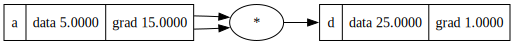

In [ ]:
d.backward()
draw_dot(d)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

 The value 0.7071067811865476
 The value 0.8813735870195432
 The value 6.881373587019543
 The value -6.0
 The value 0.0
 The value 1.0
 The value 0.0
 The value -6.0
 The value -3.0
 The value 2.0


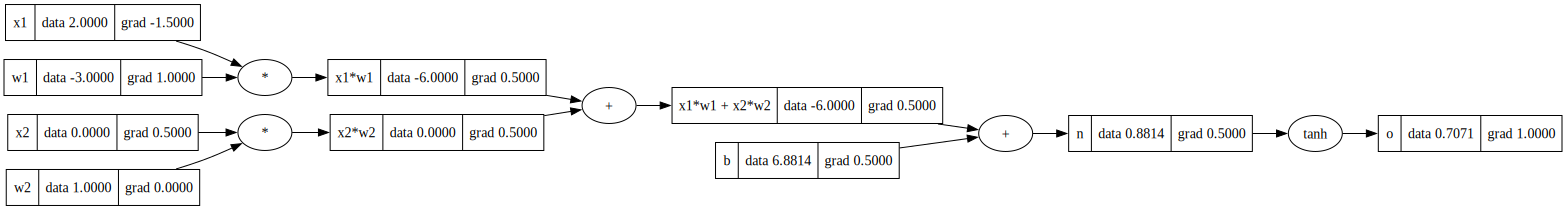

In [ ]:
draw_dot(o)





In [ ]:

o.backward()



In [458]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [601]:
def predict(n,itr, pred, exp):
    prev_loss , prev_predt = 9999.9,[]
    for i in range(itr):
        ypred = [n(x) for x in pred]
        loss = sum((yout-ygd)**2 for yout,ygd in list(zip(ypred,exp)))
        for p in n.parameter():
            p.grad = 0.0

        loss.backward()

        for p in n.parameter():
            p.data += -0.01 * p.grad
        
        if prev_loss > loss.data:
            prev_loss, prev_predt = loss.data, ypred
        else:
            print(f' Loss for {i-1, i} th itr{prev_loss, loss}')
            print(prev_predt)
            break
        # if i%50 == 0:
        #     print(f' Loss for {i} th itr{loss}')
        #     print( pred, exp)
    return loss

    

In [598]:
n = MLP(3, [4, 4, 1])

In [602]:
loss = predict(n,5,xs,ys)

 Loss for (3, 4) th itr(3.9852404465511184,  The value 3.9852496374462945)
[ The value 0.0028760032983700984,  The value 0.004781334229693582,  The value -0.0010076524604982807,  The value 0.008328208682934084]


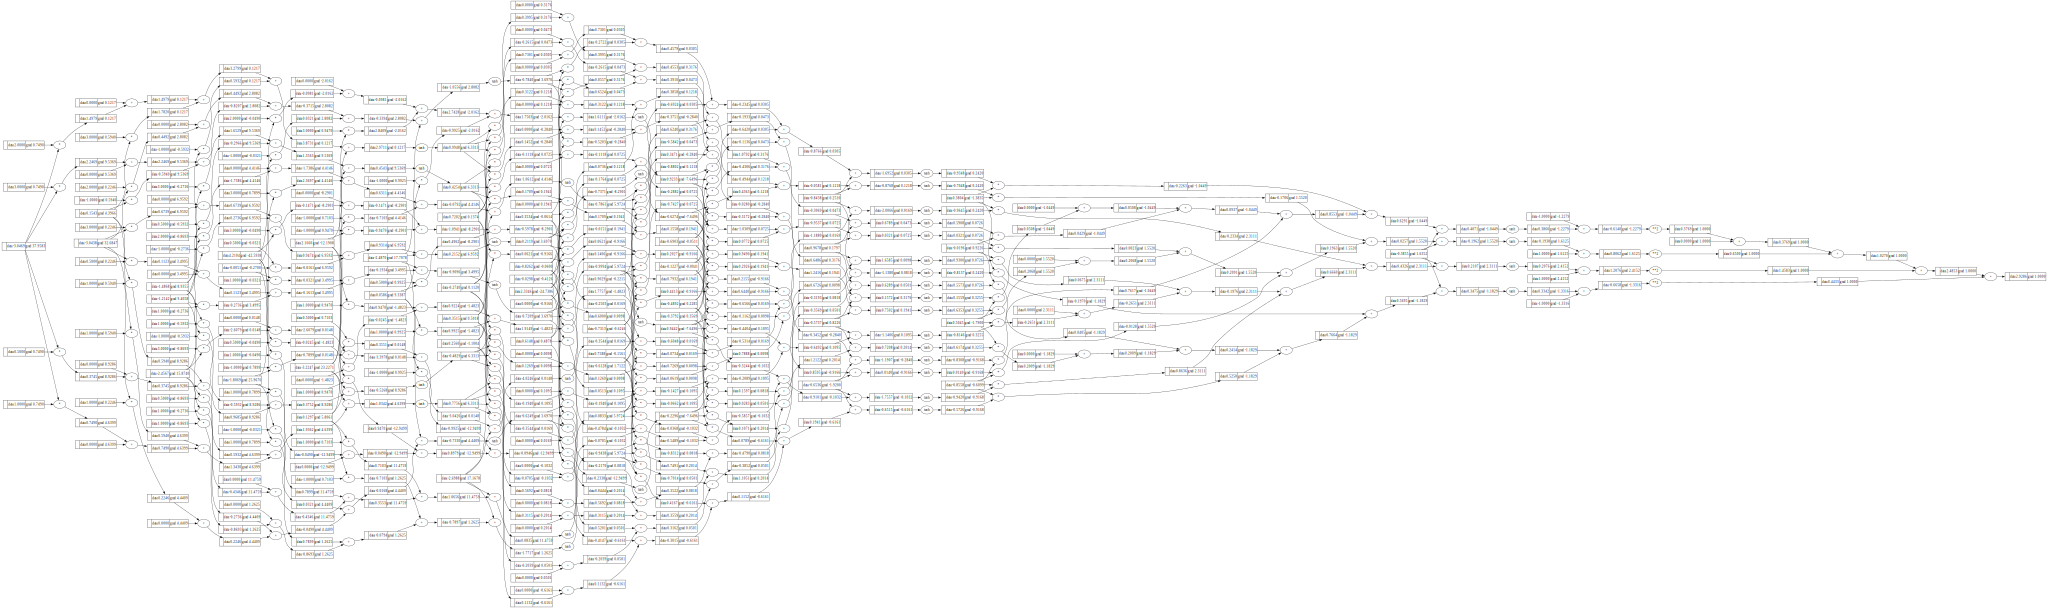

In [563]:
draw_dot1(loss)